In [1]:
import pandas as pd
import numpy as np

import scanpy as sc
import biolord

import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy.stats import ttest_rel
warnings.simplefilter("ignore", UserWarning)

Global seed set to 0


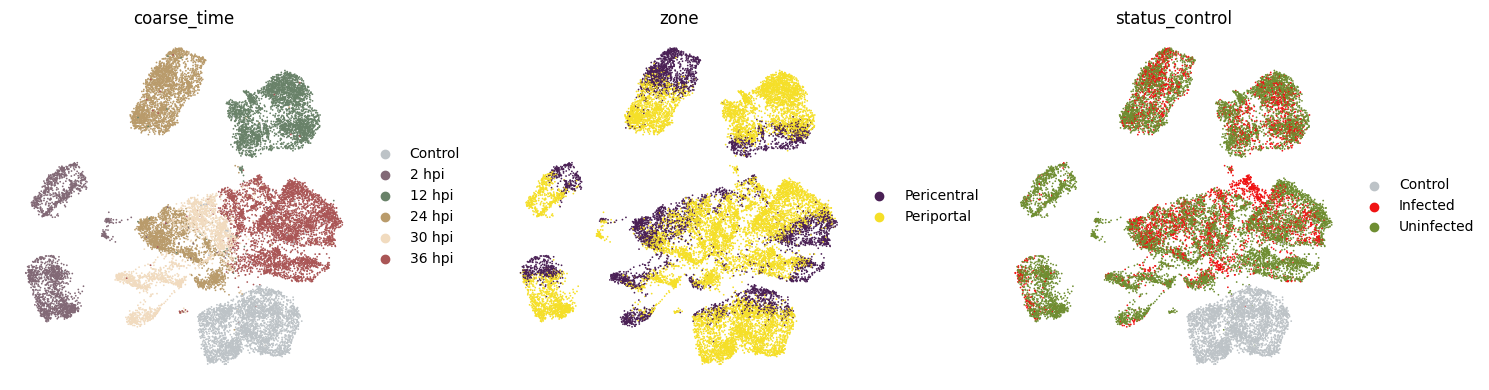

In [2]:
adata = sc.read("adata_infected.h5ad", backup_url="https://figshare.com/ndownloader/files/39375713")
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
for i, c in enumerate(["coarse_time", "zone", "status_control"]):
    sc.pl.umap(adata, color=[c], ax=axs[i], show=False)
    axs[i].set_axis_off()
plt.tight_layout()
plt.show()

In [3]:
biolord.Biolord.setup_anndata(
    adata,
    ordered_attributes_keys=None,
    categorical_attributes_keys=["time_int", "status_control", "zone"],
)

In [4]:
module_params = {
    "decoder_width": 1024,
    "decoder_depth": 4,
    "attribute_nn_width": 512,
    "attribute_nn_depth": 2,
    "n_latent_attribute_categorical": 4,
    "gene_likelihood": "normal",
    "reconstruction_penalty": 1e2,
    "unknown_attribute_penalty": 1e1,
    "unknown_attribute_noise_param": 1e-1,
    "attribute_dropout_rate": 0.1,
    "use_batch_norm": False,
    "use_layer_norm": False,
    "seed": 42,
}
model = biolord.Biolord(
    adata=adata,
    n_latent=32,
    model_name="spatio_temporal_infected",
    module_params=module_params,
    train_classifiers=False,
    split_key="split_random",
)

Global seed set to 42


In [5]:
trainer_params = {
    "n_epochs_warmup": 0,
    "latent_lr": 1e-4,
    "latent_wd": 1e-4,
    "decoder_lr": 1e-4,
    "decoder_wd": 1e-4,
    "attribute_nn_lr": 1e-2,
    "attribute_nn_wd": 4e-8,
    "step_size_lr": 45,
    "cosine_scheduler": True,
    "scheduler_final_lr": 1e-5,
}
model.train(
    max_epochs=500,
    batch_size=512,
    plan_kwargs=trainer_params,
    early_stopping=True,
    early_stopping_patience=20,
    check_val_every_n_epoch=10,
    num_workers=1,
    enable_checkpointing=False,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-80GB MIG 1g.10gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-GPU-fc991236-9668-7a85-1c2c-063ac7193c1c/13/0]


Epoch 65/500:  13%|█▎        | 65/500 [04:56<33:02,  4.56s/it, v_num=1, val_generative_mean_accuracy=0.964, val_generative_var_accuracy=0.777, val_biolord_metric=0.871, val_reconstruction_loss=18.7, val_unknown_attribute_penalty_loss=22.6, generative_mean_accuracy=0, generative_var_accuracy=0, biolord_metric=0, reconstruction_loss=18, unknown_attribute_penalty_loss=30.4]  
Monitored metric val_biolord_metric did not improve in the last 20 records. Best score: 0.873. Signaling Trainer to stop.


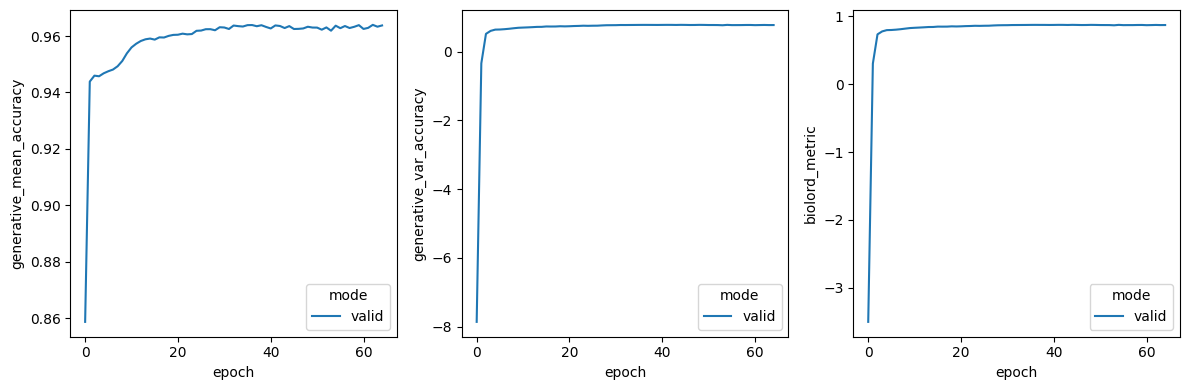

In [6]:
size = 4
vals = ["generative_mean_accuracy", "generative_var_accuracy", "biolord_metric"]
fig, axs = plt.subplots(nrows=1, ncols=len(vals), figsize=(size * len(vals), size))

model.epoch_history = pd.DataFrame().from_dict(model.training_plan.epoch_history)
for i, val in enumerate(vals):
    sns.lineplot(
        x="epoch",
        y=val,
        hue="mode",
        data=model.epoch_history[model.epoch_history["mode"] == "valid"],
        ax=axs[i],
    )

plt.tight_layout()
plt.show()

In [7]:
idx_source = np.where((adata.obs["split_random"] == "train") & (adata.obs["coarse_time"] == "Control"))[0]

adata_source = adata[idx_source].copy()

In [8]:
adata_preds = model.compute_prediction_adata(
    adata, adata_source, target_attributes=["status_control"], add_attributes=["zone", "eta_normalized"]
)

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


0it [00:00, ?it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


1it [00:00,  5.62it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


2it [00:00,  4.55it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


3it [00:01,  2.70it/s]
/software/cellgen/team361/aa34/envs/disect/lib/python3.9/site-packages/biolord/_model.py:906: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['Periportal', 'Pericentral', 'Periportal', 'Periportal', 'Periportal', ..., 'Pericentral', 'Periportal', 'Periportal', 'Periportal', 'Periportal']
Length: 2865
Categories (2, object): ['Pericentral', 'Periportal']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  adata_preds.obs.iloc[start : start + adata_source.shape[0], -1] = adata_source.obs[attribute_]


In [9]:
adata_preds = model.compute_prediction_adata(
    adata, adata_source, target_attributes=["status_control"], add_attributes=["zone", "eta_normalized"]
)

0it [00:00, ?it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


1it [00:00,  5.57it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


2it [00:00,  4.77it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


3it [00:01,  2.81it/s]
/software/cellgen/team361/aa34/envs/disect/lib/python3.9/site-packages/biolord/_model.py:906: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['Periportal', 'Pericentral', 'Periportal', 'Periportal', 'Periportal', ..., 'Pericentral', 'Periportal', 'Periportal', 'Periportal', 'Periportal']
Length: 2865
Categories (2, object): ['Pericentral', 'Periportal']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  adata_preds.obs.iloc[start : start + adata_source.shape[0], -1] = adata_source.obs[attribute_]


KeyError: "Could not find 'umap' or 'X_umap' in .obsm"

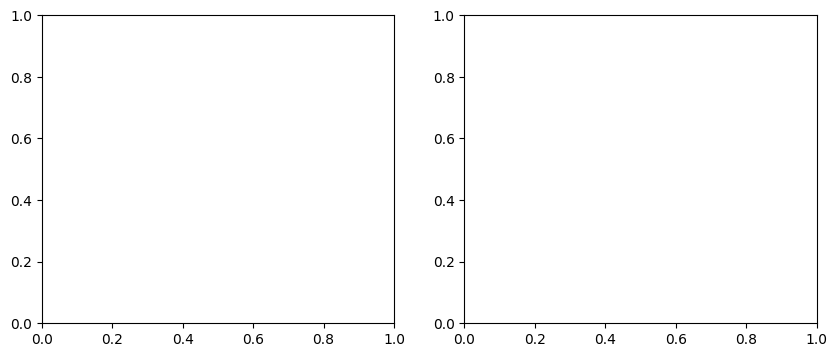

In [10]:
adata_preds.obs["status_control_counter"] = adata_preds.obs["status_control"].copy()
adata_preds.obs["status_control_counter"] = adata_preds.obs["status_control_counter"].cat.rename_categories(
    {"Infected": "Infected (c-pred.)", "Uninfected": "Uninfected (c-pred.)"}
)

adata_preds.uns["status_control_counter_colors"] = ["#bdc3c7", "#f01313", "#6f8e32"]

size = 4
fig, axs = plt.subplots(1, 2, figsize=(2 * (size + 1), size))

for i, c in enumerate(["status_control_counter", "zone"]):
    sc.pl.umap(adata_preds, color=[c], ax=axs[i], show=False)

    axs[i].set_axis_off()

plt.tight_layout()
plt.show()

In [11]:
cats = ["coarse_time", "zone", "status_control"]
for i, cat in enumerate(cats):
    nullify = [c for c in cats if c != cat]
    latent_unknown_attributes_adata, latent_adata = model.get_latent_representation_adata(
        adata=adata,
        nullify_attribute=nullify,
    )
    adata.obsm[f'Biolord_Z_{i+1}'] = latent_adata.X.copy()

    nullify = [cat]
    latent_unknown_attributes_adata, latent_adata = model.get_latent_representation_adata(
        adata=adata,
        nullify_attribute=nullify,
    )
    adata.obsm[f'Biolord_Z_not_{i+1}'] = np.concatenate([latent_adata.X.copy()], axis=1)

adata.obsm[f'Biolord_Z_0'] = latent_unknown_attributes_adata.X.copy()

In [12]:
import anndata as ad


In [13]:
for i in range(len(cats) + 1):  # loop over all Z_i
    latent_name = f'Biolord_Z_{i}'
    print(latent_name)

    latent = ad.AnnData(X=adata.obsm[f"{latent_name}"], obs=adata.obs)
    # rsc.get.anndata_to_GPU(latent)
    sc.pp.neighbors(adata=latent, use_rep='X')
    # rsc.pp.neighbors(adata=latent, use_rep='X')
    sc.tl.umap(adata=latent)
    # rsc.get.anndata_to_CPU(latent)

    adata.uns[f'{latent_name}_neighbors'] = latent.uns['neighbors']
    adata.obsm[f'{latent_name}_umap'] = latent.obsm['X_umap']

Biolord_Z_0
Biolord_Z_1
Biolord_Z_2
Biolord_Z_3


---UMAP for Biolord_Z_0---


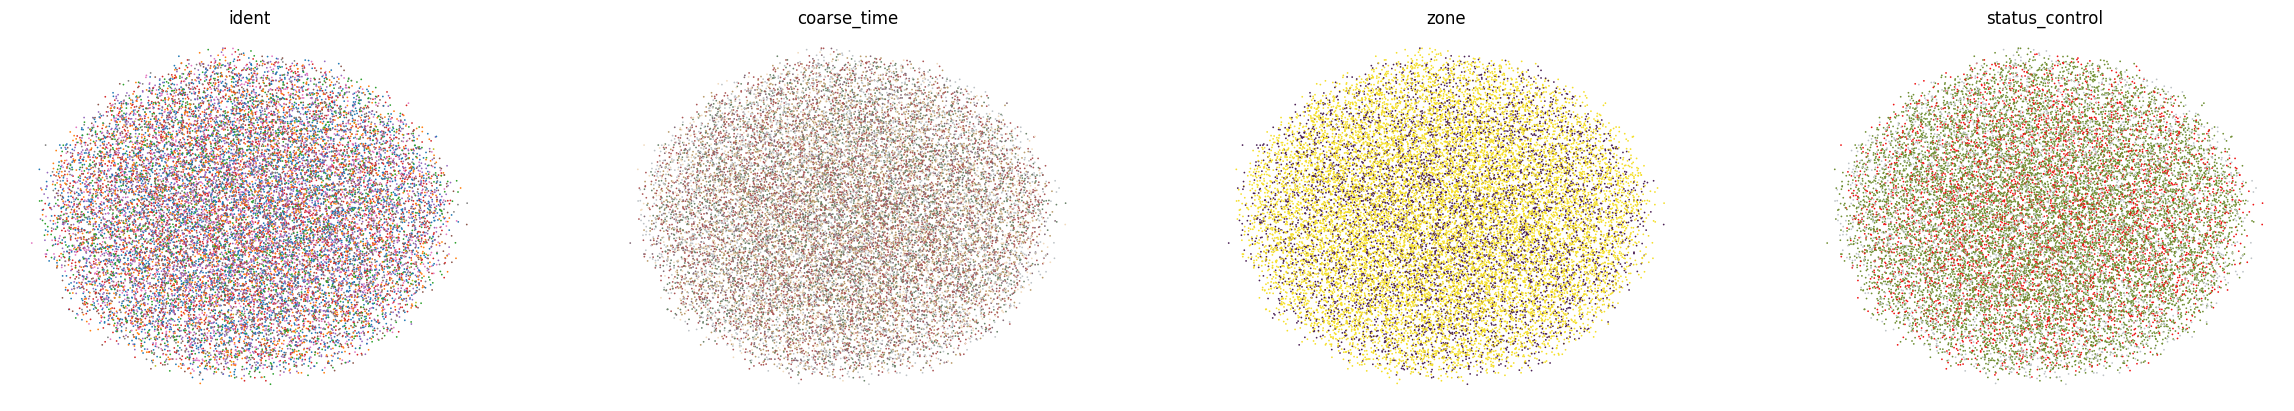

---UMAP for Biolord_Z_1---
coarse_time


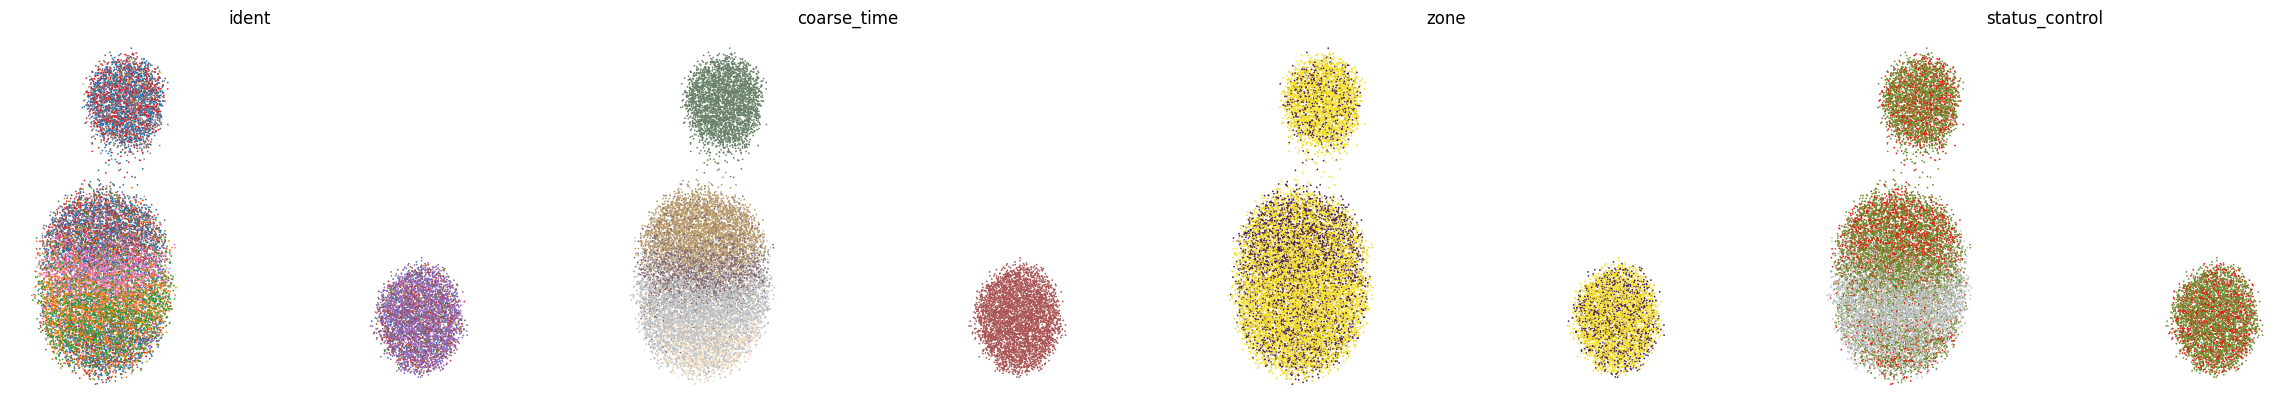

---UMAP for Biolord_Z_2---
zone


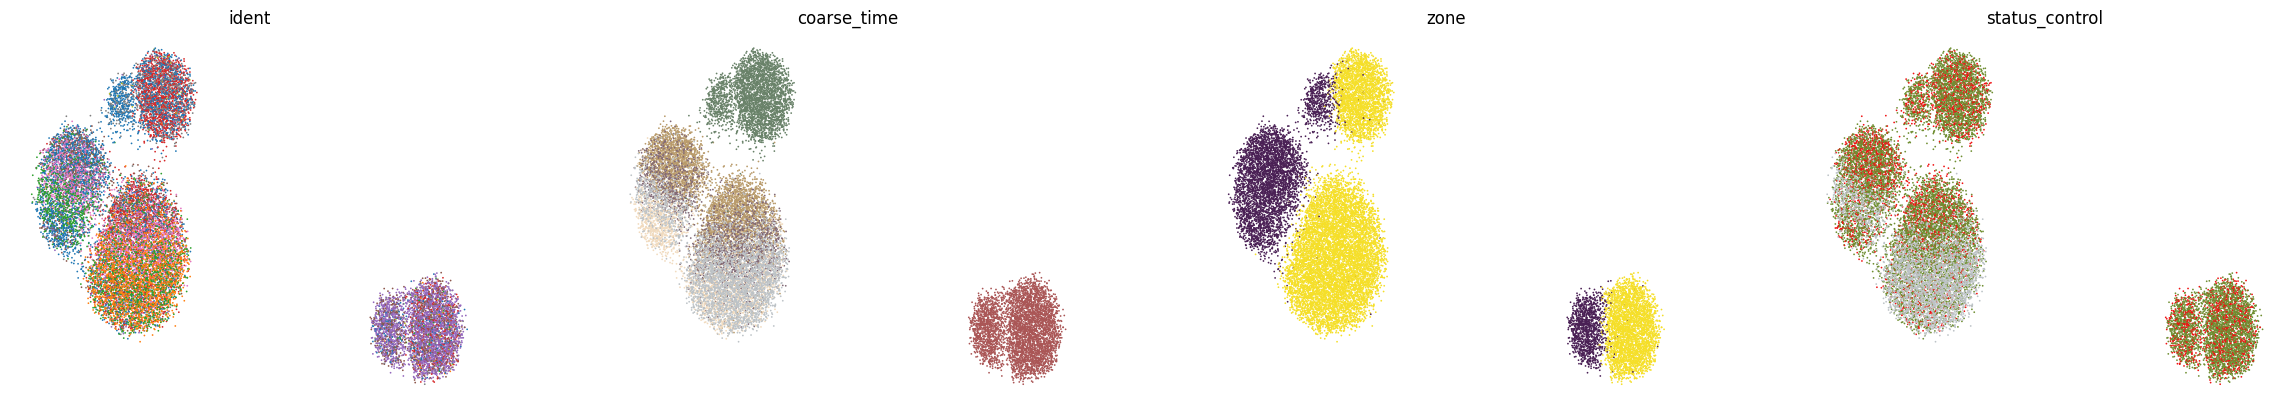

---UMAP for Biolord_Z_3---
status_control


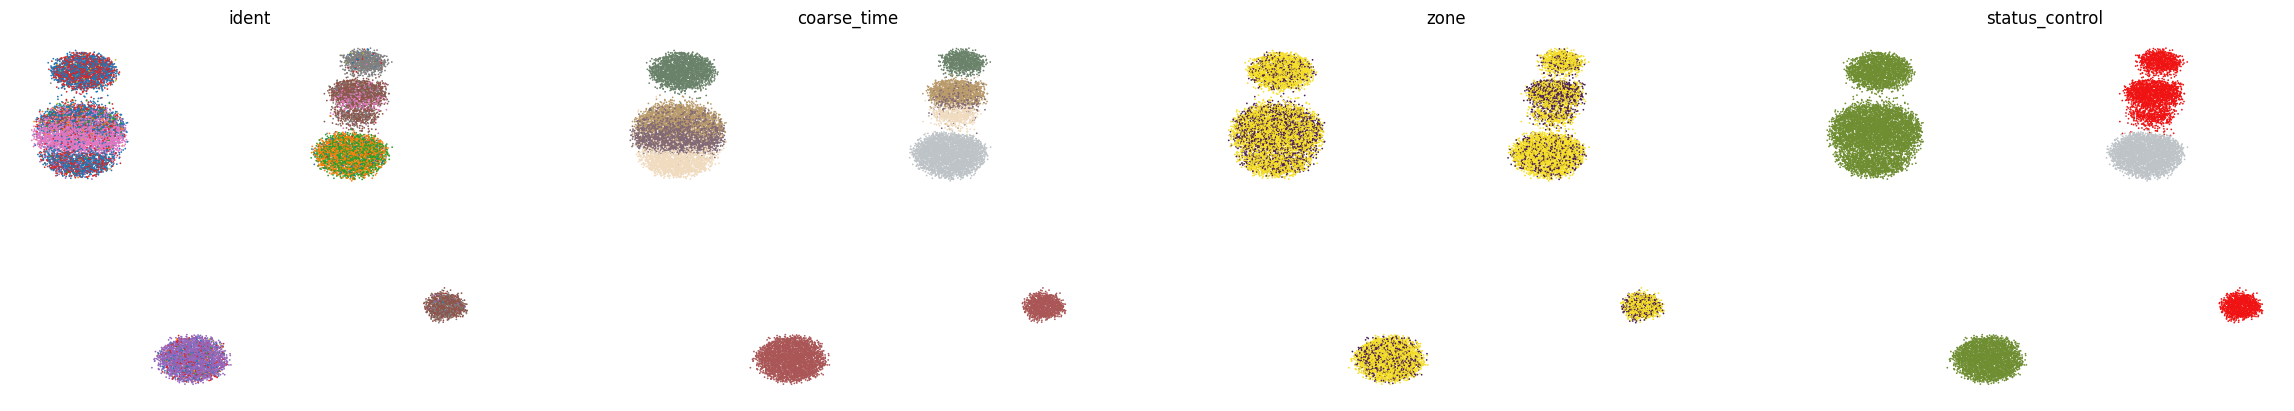

In [20]:
import warnings
import random
warnings.filterwarnings("ignore")
random.seed(0)

nrow = len(cats) + 1
ncol = len(cats)

cats_ = ["ident", "coarse_time", "zone", "status_control"]

for i in range(len(cats) + 1):  # loop over all Z_i
    latent_name = f'Biolord_Z_{i}'

    print(f"---UMAP for {latent_name}---")
    if i != 0:
        print(cats[i - 1])

    sc.pl.embedding(
        adata,
        f'{latent_name}_umap',
        color=cats_,
        ncols=len(cats_),
        frameon=False,
        legend_loc=None,
        save=f'_{latent_name}_embedding.png'  # This will save the plot
        # ax=axs[i][:]
    )

In [15]:
list(adata.obs)

['barcode',
 'mouse',
 'marker',
 'time',
 'infected',
 'experiment',
 'coarse_time',
 'MB',
 'eta',
 'n_genes_by_counts',
 'total_counts',
 'total_counts_mt',
 'pct_counts_mt',
 'mt_qc',
 'SUMPBA',
 'n_counts',
 'n_genes',
 'mus_rRNA',
 'pba_rRNA',
 'pba_rRNA_fraction',
 'nCount_PBA',
 'nFeature_PBA',
 'nCount_MUS',
 'nFeature_MUS',
 'RNA_snn_res.0.2',
 'seurat_clusters',
 'MBinfected',
 'cluster_names',
 'ident',
 'eta_normalized',
 'nCounts_tot',
 'normalized_PBA',
 'coarse_time_orig',
 'zone',
 'status',
 'status_control',
 'time_int',
 'split_random',
 '_indices',
 '_scvi_time_int',
 '_scvi_status_control',
 '_scvi_zone']

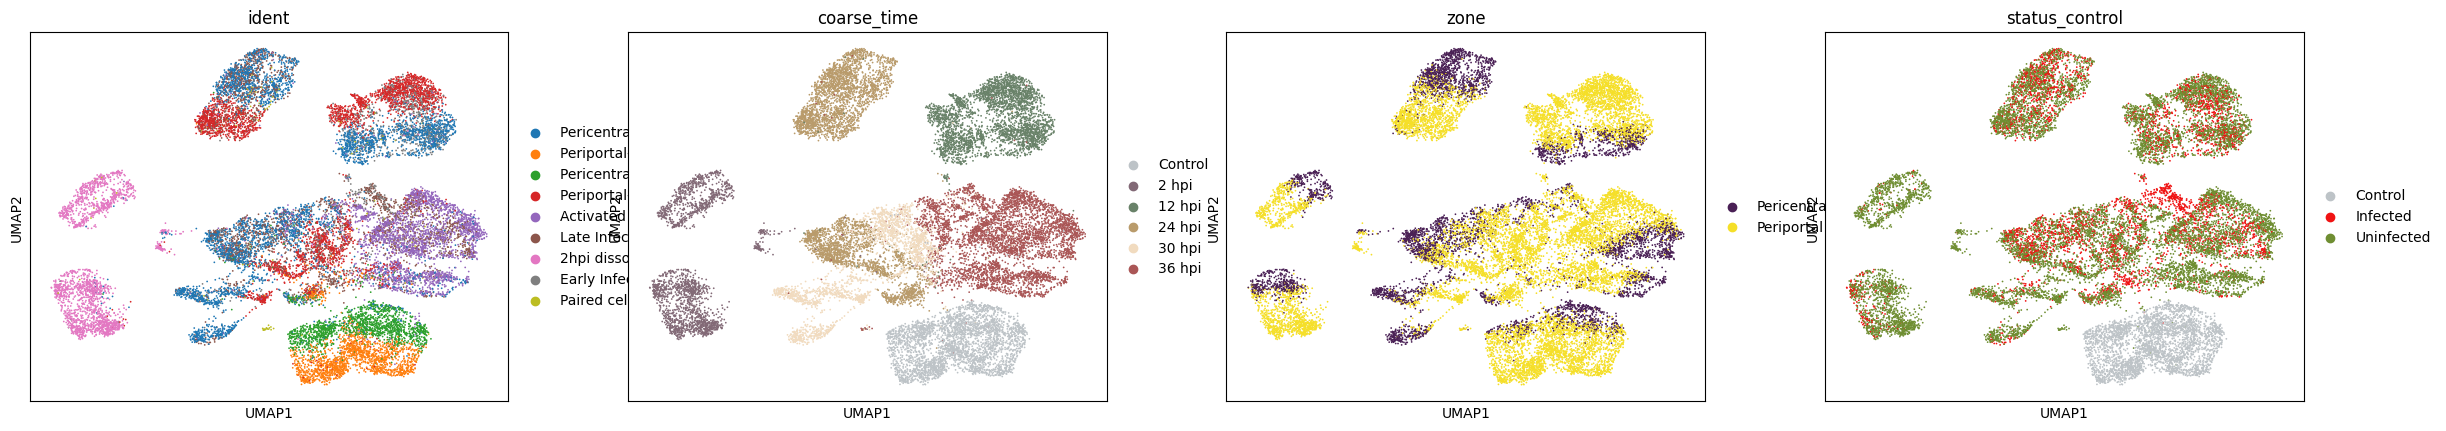

In [24]:
sc.pl.umap(adata, color=["ident", "coarse_time", "zone", "status_control"], show=True,         
    save=f'umap.png'  # This will save the plot
)

In [23]:
adata

AnnData object with n_obs × n_vars = 19053 × 8203
    obs: 'barcode', 'mouse', 'marker', 'time', 'infected', 'experiment', 'coarse_time', 'MB', 'eta', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'mt_qc', 'SUMPBA', 'n_counts', 'n_genes', 'mus_rRNA', 'pba_rRNA', 'pba_rRNA_fraction', 'nCount_PBA', 'nFeature_PBA', 'nCount_MUS', 'nFeature_MUS', 'RNA_snn_res.0.2', 'seurat_clusters', 'MBinfected', 'cluster_names', 'ident', 'eta_normalized', 'nCounts_tot', 'normalized_PBA', 'coarse_time_orig', 'zone', 'status', 'status_control', 'time_int', 'split_random', '_indices', '_scvi_time_int', '_scvi_status_control', '_scvi_zone'
    var: 'org', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'coarse_time_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'status_colors', 'status_control_colors', 'umap', 'zone_colors', '_scvi_uuid', '_scvi_manager_uuid', 'Biolord_Z_0_neighbors', 'Biolord_Z_1_neighbors', 'Biolord_Z_2_neighbors', 'Biolord